# Active Inference for Markov Decision Processes

> This notebook provides an example of the `inferactively` toolbox 

## Environments

The `inferactively` includes environments that follow the openAI `gym` API. Here, we will use a grid-world environment. We will assume that the agent is observing and acting in multiple grid environments simultaneously. This will enable us to demonstrate how *factors* are implemented in `inferactively`.

We assume $N$ grid worlds, each of some arbitary shape $w \ x \ h$. At each time step $t$, the environment generates observations about the agents positions in each grid world. Formally, it generates a vector $[o_0 , ... , o_N]$. 

Agents can take one of 5 actions in each grid world - `{UP, RIGHT, DOWN, LEFT, STAY}`, but here we will sample random actions.

In [1]:
from inferactively.envs import NDGridWorldEnv

env = NDGridWorldEnv(shape=[2, 2], n_dims=2)

obs = env.reset()
for _ in range(5):
    controls = env.sample_action()
    obs = env.step(controls)
    print(f"obs {obs} controls {controls}")

obs [3 2] controls [4 3]
obs [3 0] controls [2 0]
obs [2 0] controls [3 0]
obs [3 2] controls [1 2]
obs [2 3] controls [3 1]


### Generative model

Now we have an environment, the next step is to construct an agent's generative model (we will cover learning a model later). `inferactively` contains several useful classes for constructing models.

We consider the following generative model:
$$ p(\mathbf{o}_{1:T}, \mathbf{s}_{1:T}) = \prod_{t=1}^T p(\mathbf{o}_t|\mathbf{s}_t) p(\mathbf{s}_t|\mathbf{s}_{t-1}, \mathbf{u}_{t-1}) $$

Here, $o$ are observations, $s$ are "hidden states" - beliefs about the causes of sensory data - and $u$ are control states.

### Likelihood distribution (`A`)
            
We will begin by considering the likelihood distribution $p(\mathbf{o}_t|\mathbf{s}_t)$, which will be denoted `A` in the code.

To make inference tractble, we factorise the beliefs about hidden states, with one factor for each grid world $N$. In other words, the agent believes that its position in grid $a$ is independent of its position in grid $b$ (which it is).

This likelihood distribution is over $M$ modalities (2). Moreover, there are $N$ hidden state factors (10). In practice, a separate likelihood distribution is maintained for each modality $m$, i.e $p(o_t^m|s_t)$, each of which has the dimensions `(o_m, s_0, ..., s_N)`

For simplicity, we will assume that each hidden state factor maps to a corresponding observation modality, and that this map is an identity mapping. In short, agents have perfect knowledge about where there are in the world. Later, we will introduce uncertainty into the inference procedure.

> _Note: number of hidden states will be `w x h` for each factor_

This can be implemented as follows:

Number of states per factor [4, 4] Number of observations per modality [4, 4]
Number of state factors 2 Number of modalities 2


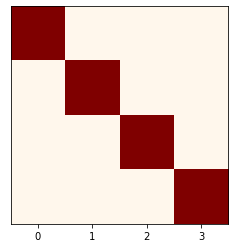

None


In [11]:
import numpy as np
from inferactively.distributions import Categorical

n_observations = env.n_observations
n_states = env.n_states
print(f"Number of states per factor {n_states} Number of observations per modality {n_observations}")

n_modalities = len(n_observations)
n_factors = len(n_states)
print(f"Number of state factors {n_factors} Number of modalities {n_modalities}")

A = np.empty(n_modalities, dtype="object")
for m in range(n_modalities):
    dist = np.zeros((n_observations[m], *n_states))
    dist[:, :, :] = np.eye(n_states[0])
    A[m] = dist
A = Categorical(values=A)
print(A[0].plot())


In [5]:
from inferactively.core import update_posterior_states

qs = update_posterior_states(A, obs)

IndexError: tuple index out of range